<h1><center><font size="25">Predicción (<i>forecasting</i>) visitas página web con machine learning</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>Septiembre, 2021 (última actualización Septiembre 2022)</i></center>

Más sobre ciencia de datos: [**cienciadedatos.net**](https://cienciadedatos.net)

+ [Forecasting series temporales con Python y Scikit Learn](https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html)
+ [Predicción (forecasting) de la demanda eléctrica con Python](https://www.cienciadedatos.net/documentos/py29-forecasting-demanda-energia-electrica-python.html)
+ [Forecasting series temporales con gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-series-temporales-con-skforecast-xgboost-lightgbm-catboost.html)
+ [Predicción del precio de Bitcoin con Python](https://www.cienciadedatos.net/documentos/py41-forecasting-criptomoneda-bitcoin-machine-learning-python.html)
+ [Intervalos de predicción en modelos de forecasting](https://www.cienciadedatos.net/documentos/py42-intervalos-prediccion-modelos-forecasting-machine-learning.html)

## Introducción
<br>

Una serie temporal (*time series*) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de *forecasting* consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

En este documento se muestra un ejemplo de cómo utilizar métodos *machine learning* y modelado estadístico (ARIMA) para predecir el número de visitas diarias que recibe una página web. Para ello, se hace uso de [**skforecast**](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html), una sencilla librería de Python que permite, entre otras cosas, adaptar cualquier regresor de scikit-learn a problemas de *forecasting*.
<br><br>

## Caso de uso
<br>

Se dispone del historial de visitas diarias a la web [cienciadedatos.net](https://www.cienciadedatos.net) desde el 01/07/2020. Se pretende generar un modelo de *forecasting* capaz de predecir el tráfico web que tendrá la página a 7 días vista. En concreto, el usuario quiere ser capaz de ejecutar el modelo cada lunes y obtener las predicciones de tráfico diario hasta el lunes siguiente.

Con el objetivo de poder evaluar de forma robusta la capacidad del modelo acorde al uso que se le quiere dar, conviene no limitarse a predecir únicamente los últimos 7 días de la serie temporal, sino simular el proceso completo. El [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html) es un tipo especial de *cross-validation* que se aplica al periodo o periodos anteriores y puede emplearse con diferentes estrategias:

**Backtesting con reentrenamiento (refit)**

El modelo se entrena cada vez antes de realizar las predicciones, de esta forma, se incorpora toda la información disponible hasta el momento. Se trata de una adaptación del proceso de *cross-validation* en el que, en lugar de hacer un reparto aleatorio de las observaciones, el conjunto de entrenamiento se incrementa de forma secuencial, manteniendo el orden temporal de los datos.

<p align="center"><img src="./images/diagram-backtesting-refit.png" style="width: 500px;"></p>

<p align="center"><img src="./images/backtesting_refit.gif" style="width: 600px;"></p>


**Backtesting with refit and fixed training size (rolling origin)**

Una técnica similar a la anterior pero, en este caso, el origen de los datos de forecasting se desplaza hacia delante, por lo que el tamaño del entrenamiento se mantiene constante. También se conoce como *walk-forward validation*.

<p align="center"><img src="./images/diagram-backtesting-refit-fixed-train-size.png" style="width: 500px;"></p>

<p align="center"><img src="./images/backtesting_refit_fixed_train_size.gif" style="width: 600px;"></p>


**Backtesting sin reentrenamiento**

Con esta estrategia, el modelo se entrena una única vez con un conjunto inicial y se realizan las predicciones de forma secuencial sin actualizar el modelo y siguiendo el orden temporal de los datos. Esta estrategia tiene la ventaja de ser mucho más rápida puesto que el modelo solo se entrena una vez. La desventaja es que el modelo no incorpora la última información disponible por lo que puede perder capacidad predictiva con el tiempo.

<p align="center"><img src="./images/diagram-backtesting-no-refit.png" style="width: 500px;"></p>

<p align="center"><img src="./images/backtesting_no_refit.gif" style="width: 600px;"></p>

<br>


El método de validación más adecuada dependerá de cuál sea la estrategia seguida en la puesta en producción, en concreto, de si el modelo se va a reentrenar periódicamente o no antes de que se ejecute el proceso de predicción. Independientemente de la estrategia utilizada, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de *overfitting*.

## Librerías
<br>

Las librerías utilizadas en este documento son:

In [32]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_statsmodels import backtesting_sarimax
from skforecast.model_selection_statsmodels import grid_search_sarimax

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Datos
<br>

Los datos empleados en este documento se han obtenido a partir del servicio de google analytics integrado en la página y pueden descargarse de [aquí](https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/blob/master/data/visitas_por_dia_web_cienciadedatos.csv). Los campos incluidos son:

+ date: fecha en formato dia/mes/año

+ users: número total de personas que visitan la web

In [2]:
# Descarga de datos
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/' +
       'master/data/visitas_por_dia_web_cienciadedatos.csv')
datos = pd.read_csv(url, sep=',')
datos.head()

,date,users
0,1/7/20,2324
1,2/7/20,2201
2,3/7/20,2146
3,4/7/20,1666
4,5/7/20,1433


La columna *date* se ha almacenado como `string`. Para convertirla en formato fecha, se emplea la función `pd.to_datetime()`. Una vez en formato `datetime`, y para hacer uso de las funcionalidades de **pandas**, se establece como índice. Además, dado que los datos son de carácter diario, se indica la frecuencia ('1D').

In [3]:
# Conversión del formato fecha
# ==============================================================================
datos['date'] = pd.to_datetime(datos['date'], format='%d/%m/%y')
datos = datos.set_index('date')
datos = datos.asfreq('1D')
datos = datos.sort_index()

In [4]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
                ).all()

True

In [5]:
print(f"Valores missing: {datos.isnull().any(axis=1).sum()}")

Valores missing: 0


El set de datos empieza el *2020-07-01* y termina el *2021-08-22*. Se dividen los datos en 3 conjuntos, uno de entrenamiento, uno de validación y otro de test.

In [6]:
# Separación datos train-test
# ==============================================================================
fin_train = '2021-03-30 23:59:00'
fin_validacion = '2021-06-30 23:59:00'

datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validación : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2020-07-01 00:00:00 --- 2021-03-30 00:00:00  (n=273)
Fechas validación : 2021-03-31 00:00:00 --- 2021-06-30 00:00:00  (n=92)
Fechas test       : 2021-07-01 00:00:00 --- 2021-08-25 00:00:00  (n=56)


## Exploración gráfica
<br>

Cuando se quiere generar un modelo de *forecasting*, es importante representar los valores de la serie temporal. Esto permite identificar patrones tales como tendencias y estacionalidad.

**Serie temporal completa**

In [7]:
# Gráfico serie temporal
# ==============================================================================
# fig, ax = plt.subplots(figsize=(12, 4))
# datos_train.users.plot(ax=ax, label='train', linewidth=1)
# datos_val.users.plot(ax=ax, label='val', linewidth=1)
# datos_test.users.plot(ax=ax, label='test', linewidth=1)
# ax.set_title('Visitas diarias a cienciadedatos.net')
# ax.legend();

plot_train = datos_train.users.hvplot.line(label='train')
plot_val = datos_val.users.hvplot.line(label='val')
plot_test = datos_test.users.hvplot.line(label='test')

layout = plot_train * plot_val * plot_test
layout = layout.opts(title='Visitas diarias a cienciadedatos.net', ylabel='users')
layout

:Overlay
   .Curve.Train :Curve   [date]   (users)
   .Curve.Val   :Curve   [date]   (users)
   .Curve.Test  :Curve   [date]   (users)

**Estacionalidad anual, mensual y semanal**

In [8]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# datos['mes'] = datos.index.month
# datos.boxplot(column='users', by='mes', ax=ax,)
# datos.groupby('mes')['users'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('users')
# ax.set_title('Distribución de visitas por mes')
# fig.suptitle('');

datos['mes'] = datos.index.month
boxplot  = datos.sort_values('mes').hvplot.box(
               y                  = 'users',
               by                 = 'mes',
               legend             = False,
               box_fill_color     = None,
               outlier_fill_color = None
           )
lineplot = datos.groupby('mes')['users'].median().hvplot.line(legend=False)
scatterplot = datos.groupby('mes')['users'].median().hvplot.scatter(legend=False)
layout = boxplot * lineplot * scatterplot
layout = layout.opts(title='Distribución de visitas por mes', ylabel='users', width=600)
layout

:Overlay
   .BoxWhisker.I  :BoxWhisker   [mes]   (users)
   .Curve.Users   :Curve   [mes]   (users)
   .Scatter.Users :Scatter   [mes]   (users)

In [9]:
# Gráfico boxplot para estacionalidad mensual
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# datos['dia_mes'] = pd.Series(datos.index).dt.day.values
# datos.boxplot(column='users', by='dia_mes', ax=ax,)
# datos.groupby('dia_mes')['users'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('users')
# ax.set_title('Distribución de visitas por día del mes')
# fig.suptitle('');

datos['dia_mes'] = pd.Series(datos.index).dt.day.values
boxplot = datos.hvplot.box(
              y                  = 'users',
              by                 = 'dia_mes',
              legend             = False,
              box_fill_color     = None,
              outlier_fill_color = None
          )
lineplot = datos.groupby('dia_mes')['users'].median().hvplot.line(legend=False)
scatterplot = datos.groupby('dia_mes')['users'].median().hvplot.scatter(legend=False)
layout = boxplot * lineplot * scatterplot
layout = layout.opts(title='Distribución de visitas por día del mes', ylabel='users', width=600)
layout

:Overlay
   .BoxWhisker.I  :BoxWhisker   [dia_mes]   (users)
   .Curve.Users   :Curve   [dia_mes]   (users)
   .Scatter.Users :Scatter   [dia_mes]   (users)

In [10]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# datos['dia_semana'] = datos.index.day_of_week + 1
# datos.boxplot(column='users', by='dia_semana', ax=ax)
# datos.groupby('dia_semana')['users'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('users')
# ax.set_title('Distribución visitas por día de la semana')
# fig.suptitle('');

datos['dia_semana'] = datos.index.day_of_week + 1
boxplot = datos.sort_values('dia_semana').hvplot.box(
              y                  = 'users',
              by                 = 'dia_semana',
              legend             = False,
              box_fill_color     = None,
              outlier_fill_color = None
          )
lineplot = datos.groupby('dia_semana')['users'].median().hvplot.line(legend=False)
scatterplot = datos.groupby('dia_semana')['users'].median().hvplot.scatter(legend=False)
layout = boxplot * lineplot * scatterplot
layout = layout.opts(
             title  = 'Distribución de visitas por día de la semana',
             ylabel = 'users',
             width  = 600
         )
layout

:Overlay
   .BoxWhisker.I  :BoxWhisker   [dia_semana]   (users)
   .Curve.Users   :Curve   [dia_semana]   (users)
   .Scatter.Users :Scatter   [dia_semana]   (users)

Al no disponer de dos años de histórico completos, no se puede determinar si existe una estacionalidad anual. Sí se aprecia una estacionalidad semanal, con una reducción del tráfico web los fines de semana.

**Gráficos de autocorrelación**

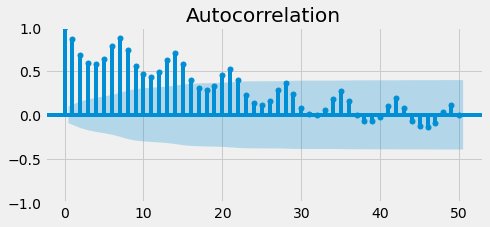

In [11]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datos.users, ax=ax, lags=50)
plt.show()

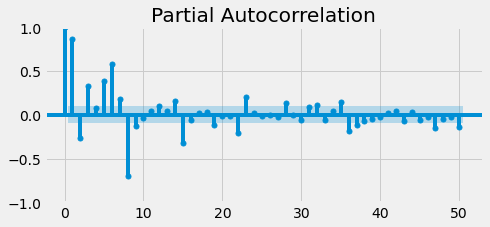

In [12]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(datos.users, ax=ax, lags=50)
plt.show()

Los gráficos de autocorrelación y autocorrelación parcial muestran una clara asociación entre el número de usuarios un día y los días anteriores. Este tipo de correlación, es un indicativo de que los modelos autorregresivos pueden funcionar bien.
<br><br>

## Modelo autoregresivo recursivo
<br>

Se crea y entrena un modelo autorregresivo recursivo (`ForecasterAutoreg`) a partir de un modelo de [regresión lineal con penalización Ridge](https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html) y una ventana temporal de 2 semanas (14 lags). Esto último significa que, para cada predicción, se utilizan como predictores el tráfico que tuvo la página los 14 días anteriores.

Los modelos Ridge requieren que los predictores se estandaricen. Con este fin, se utiliza el argumento `transformer_y` para incorporar un `StandarScaler` en el forecaster. Para conocer más sobre el uso dtransformers consultar [Forecasting with scikit-learn and transformers pipelines](https://joaquinamatrodrigo.github.io/skforecast/0.5.0/user_guides/sklearn-transformers-and-pipeline.html).

### Entrenamiento del Forecaster

In [13]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 14,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=datos_train.users)
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 14 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-07-01 00:00:00'), Timestamp('2021-03-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-09-30 20:00:19 
Last fit date: 2022-09-30 20:00:19 
Skforecast version: 0.5.0 
Python version: 3.9.13 

### Predicción (*backtest*)
<br>

Se evalúa el comportamiento que habría tenido el modelo si se hubiese entrenado con los datos desde 2020-07-01 al 2021-06-30 y, después, se realizasen predicciones de 7 en 7 días sin reentrenar el modelo. A este tipo de evaluación se le conoce como *backtesting*, y puede aplicarse fácilmente con la función `backtesting_forecaster()`. Esta función devuelve, además de las predicciones, una métrica de error.

In [14]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos.users,
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            steps              = 7,
                            refit              = False,
                            fixed_train_size   = False,
                            metric             = 'mean_absolute_error',
                            verbose            = True
                        )

print(f'Error backtest: {metrica}')
predicciones.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7

Data partition in fold: 0
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-01 00:00:00 -- 2021-07-07 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-08 00:00:00 -- 2021-07-14 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-15 00:00:00 -- 2021-07-21 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-22 00:00:00 -- 2021-07-28 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-29 00:00:00 --

,pred
2021-07-01,3199.921107
2021-07-02,2998.675773
2021-07-03,2256.899442
2021-07-04,2038.767690
2021-07-05,2998.858487


In [15]:
# Gráfico
# ==============================================================================
# fig, ax = plt.subplots(figsize=(10, 3))
# datos_test.loc[predicciones.index, 'users'].plot(ax=ax, linewidth=2, label='test')
# predicciones.plot(linewidth=2, label='predicción', ax=ax)
# ax.set_title('Predicción (Autoreg-Ridge) vs vistas reales')
# ax.legend();

plot_test = datos_test.users.hvplot.line(label='test')
plot_predict = predicciones.hvplot.line(label='predicción')
layout = plot_test * plot_predict
layout = layout.opts(
             title = 'Predicción (Autoreg-Ridge) vs vistas reales',
             ylabel = 'users',
             legend_position = 'bottom_left'
         )
layout

:Overlay
   .Curve.Test       :Curve   [date]   (users)
   .Curve.Predicción :Curve   [index]   (pred)

### Optimización de hiperparámetros (*tuning*)
<br>

En el apartado anterior, se han utilizado los primeros 14 lags como predictores y un modelo [Ridge](https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html) con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados.

Con el objetivo de identificar la mejor combinación de lags e hiperparámetros, se recurre a un *Grid Search*. Este proceso consiste en entrenar un modelo con cada combinación de hiperparámetros y lags, y evaluar su capacidad predictiva mediante *backtesting*.

En el proceso de búsqueda es importante evaluar los modelos utilizando únicamente los datos de validación y no incluir los de test, estos se utilizan solo en último lugar para evaluar al modelo final.

In [16]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 14,
                 transformer_y = StandardScaler()
             )

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Lags utilizados como predictores
lags_grid = [7, 14, 21, [7, 14, 21]]

resultados_grid = grid_search_forecaster(
                      forecaster         = forecaster,
                      y                  = datos.loc[:fin_validacion, 'users'],
                      param_grid         = param_grid,
                      lags_grid          = lags_grid,
                      steps              = 7,
                      metric             = 'mean_absolute_error',
                      refit              = False,
                      initial_train_size = len(datos_train),
                      fixed_train_size   = False,
                      return_best        = True,
                      verbose            = False
                  )

Number of models compared: 40.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:01<00:00,  2.11it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 2.154434690031882}
  Backtesting metric: 214.79167668434636



In [17]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_absolute_error,alpha
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 2.154434690031882},214.791677,2.154435
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.46415888336127775},216.551409,0.464159
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.1},217.770757,0.100000
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.021544346900318832},218.127429,0.021544
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.004641588833612777},218.206475,0.004642
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.001},218.223609,0.001000
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 10.0},219.315042,10.000000
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 10.0},220.932702,10.000000
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 2.154434690031882},221.500069,2.154435
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},226.720683,0.464159


Los mejores resultados se obtienen si se utilizan los lags [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] y una configuración de *Ridge* {'alpha': 2.154}. Al indicar `return_best = True` en la función `grid_search_forecaster()`, al final del proceso, se reentrena automáticamente el objeto forecaster con la mejor configuración encontrada y el set de datos completo.

In [18]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=2.154434690031882, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 14 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-07-01 00:00:00'), Timestamp('2021-06-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 2.154434690031882, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-09-30 20:00:19 
Last fit date: 2022-09-30 20:00:21 
Skforecast version: 0.5.0 
Python version: 3.9.13 

Una vez identificado el mejor modelo, se entrena utilizando tanto el conjunto de entrenamiento como el de validación y se calcula su error con el conjunto de test. 

In [19]:
# Backtest modelo final (conjunto de test)
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos.users,
                            initial_train_size = len(datos.loc[:fin_validacion, :]),
                            steps              = 7,
                            refit              = False,
                            fixed_train_size   = False,
                            metric             = 'mean_absolute_error',
                            verbose            = True
                        )

print(f'Error backtest: {metrica}')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7

Data partition in fold: 0
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-01 00:00:00 -- 2021-07-07 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-08 00:00:00 -- 2021-07-14 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-15 00:00:00 -- 2021-07-21 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-22 00:00:00 -- 2021-07-28 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-29 00:00:00 --

Tras la optimización de lags e hiperparámetros, se ha conseguido reducir el error de predicción.
<br><br>

## Modelo ARIMA
<br>

Para entrenar un modelo ARIMA, se puede emplear la clase [SARIMAX](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html) de statsmodels. En concreto, un modelo SARIMAX equivale a un modelo ARIMA si el argumento *seasonal_order = (0, 0, 0, 0)* y *trend = 'c'*. Con las funciones `backtesting_sarimax_statsmodels()` y `cv_sarimax_statsmodels()` de módulo `model_selection_statsmodels` de la librería [skforecast](https://github.com/JoaquinAmatRodrigo/skforecast), se pueden obtener las predicciones acorde a cómo se habría comportado el modelo.

In [20]:
# Backtest ARIMA
# ==============================================================================
metrica, predicciones = backtesting_sarimax(
                            y                  = datos.users,
                            order              = (14, 0, 0),
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = True,
                            fit_kwargs         = {'maxiter': 500, 'disp': 0}
                        )

print(f'Error backtest: {metrica}')
predicciones.head(5)

Number of observations used for training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7
Error backtest: 212.0310574381383


,predicted_mean,lower users,upper users
2021-07-01,3167.085128,2647.153980,3687.016276
2021-07-02,2978.461443,2265.072869,3691.850016
2021-07-03,2235.021529,1442.052137,3027.990921
2021-07-04,1997.450190,1128.958272,2865.942108
2021-07-05,2974.884228,2040.209516,3909.558939


In [21]:
# fig, ax = plt.subplots(figsize=(10, 3))
# datos_test.loc[predicciones.index, 'users'].plot(linewidth=2, label='test', ax=ax)
# predicciones.plot(linewidth=2, label='predicción', ax=ax)
# ax.set_title('Predicción (ARIMA) vs vistas reales')
# ax.legend();

plot_test = datos_test.users.hvplot.line(label='test')
plot_predict = predicciones['predicted_mean'].hvplot.line(label='predicción')
layout = plot_test * plot_predict
layout = layout.opts(
             title = 'Predicción (ARIMA) vs vistas reales',
             ylabel = 'users',
             legend_position = 'bottom_left'
         )
layout

:Overlay
   .Curve.Test       :Curve   [date]   (users)
   .Curve.Predicción :Curve   [index]   (predicted_mean)

### Optimización de hiperparámetros (*tuning*)
<br>

Al igual que la mayoría de modelos, ARIMA tienen una serie de hiperparámetros que controlan su comportamiento:

+ p: número de lags incluidos como predictores en el modelo autoregresivo.

+ d: número de veces que se diferencian los datos, esto es el número de veces que a cada valor se le resta el valor anterior.

+ q: tamaño de ventana para la media móvil.

En la implementación de statsmodels, estos hiperparámetros se indican a través del argumento `order`. Dos buenas referencias para conocer más detalles de los modelos ARIMA son:  https://openforecast.org/adam/ARIMA.html y https://otexts.com/fpp3/arima.html.


Con la función `grid_search_sarimax` se puede realizar una búsqueda de hiperparámetros comparando los modelos acorde a una métrica obtenida por validación cruzada o backtesting, o por las métricas aic y bic. 

In [22]:
# Grid search de hiperparámetros
# ==============================================================================
param_grid = {'order': [(14, 0, 0), (14, 2, 0), (14, 1, 0), (14, 1, 1), (14, 1, 4),
                        (21, 0, 0), (21, 0, 0), (21, 1, 0), (21, 1, 1), (21, 1, 4)]}

results = grid_search_sarimax(
              y       = datos.users,
              param_grid = param_grid,
              initial_train_size = len(datos.loc[:fin_validacion]),
              steps   = 7,
              metric  = 'mean_absolute_error',
              refit   = False,
              verbose = False,
              fit_kwargs = {'maxiter': 200, 'disp': 0}
          )

results

root       INFO  Number of models compared: 10
100%|█████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.57s/it]


,params,metric,order,seasonal_order,trend
8,"{'order': (21, 1, 1), 'seasonal_order': (0, 0,...",181.326152,"(21, 1, 1)","(0, 0, 0, 0)",None
7,"{'order': (21, 1, 0), 'seasonal_order': (0, 0,...",182.100677,"(21, 1, 0)","(0, 0, 0, 0)",None
5,"{'order': (21, 0, 0), 'seasonal_order': (0, 0,...",185.579786,"(21, 0, 0)","(0, 0, 0, 0)",None
6,"{'order': (21, 0, 0), 'seasonal_order': (0, 0,...",185.579786,"(21, 0, 0)","(0, 0, 0, 0)",None
3,"{'order': (14, 1, 1), 'seasonal_order': (0, 0,...",193.904636,"(14, 1, 1)","(0, 0, 0, 0)",None
2,"{'order': (14, 1, 0), 'seasonal_order': (0, 0,...",194.076334,"(14, 1, 0)","(0, 0, 0, 0)",None
1,"{'order': (14, 2, 0), 'seasonal_order': (0, 0,...",201.139042,"(14, 2, 0)","(0, 0, 0, 0)",None
9,"{'order': (21, 1, 4), 'seasonal_order': (0, 0,...",203.223350,"(21, 1, 4)","(0, 0, 0, 0)",None
0,"{'order': (14, 0, 0), 'seasonal_order': (0, 0,...",212.031057,"(14, 0, 0)","(0, 0, 0, 0)",None
4,"{'order': (14, 1, 4), 'seasonal_order': (0, 0,...",218.778191,"(14, 1, 4)","(0, 0, 0, 0)",None


In [23]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_sarimax(
                            y                  = datos.users,
                            order              = (21, 1, 1),
                            seasonal_order     = (0, 0, 0, 0),
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = True,
                            fit_kwargs         = {'maxiter': 250, 'disp': 0}
                        )

print(f'Error backtest: {metrica}')

Number of observations used for training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7
Error backtest: 181.3261523871715


## Forecasting con variables exógenas
<br>

En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable objetivo. En ciertos escenarios, es posible disponer de información sobre otras variables, **cuyo valor a futuro se conoce**, y que pueden servir como predictores adicionales en el modelo. Algunos ejemplos típicos son:

+ Festivos (local, nacional...)

+ Mes del año

+ Día de la semana

+ Hora del día

En este caso de uso, el análisis gráfico mostraba evidencias de que, los fines de semana, el número de visitas a la web se reduce. El día de la semana al que corresponde cada fecha puede saberse a futuro, por lo que se puede emplear como variable exógena. Véase cómo afecta a los modelos si se incluye como predictor está información.

In [24]:
# Creación de nuevas variables exógenas
# ==============================================================================
datos=datos.drop(columns=['mes', 'dia_mes'])
# One hot encoding del día de la semana y la hora del día
datos=pd.get_dummies(datos, columns=['dia_semana'])
datos.head(3)

,users,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,dia_semana_7
date,,,,,,,,
2020-07-01,2324,0,0,1,0,0,0,0
2020-07-02,2201,0,0,0,1,0,0,0
2020-07-03,2146,0,0,0,0,1,0,0


In [25]:
# Separación datos train-test
# ==============================================================================
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

### ForecasterAutoreg

In [26]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(alpha=2.15, random_state=123),
                 lags          = 14,
                 transformer_y = StandardScaler()
             )

col_exog = [column for column in datos.columns if column.startswith(('dia'))]
forecaster.fit(y=datos_train.users, exog=datos_train[col_exog])

# Backtest modelo con variables exógenas
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos.users,
                            exog               = datos[col_exog],
                            initial_train_size = len(datos.loc[:fin_validacion, :]),
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = True
                        )

print(f'Error backtest: {metrica}')
predicciones.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7

Data partition in fold: 0
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-01 00:00:00 -- 2021-07-07 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-08 00:00:00 -- 2021-07-14 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-15 00:00:00 -- 2021-07-21 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-22 00:00:00 -- 2021-07-28 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-29 00:00:00 --

,pred
2021-07-01,3286.890749
2021-07-02,3021.079567
2021-07-03,2256.401254
2021-07-04,1985.650262
2021-07-05,3039.877224


### ARIMA

In [27]:
# Backtest modelo con variables exógenas
# ==============================================================================
metrica, predicciones = backtesting_sarimax(
                            y                  = datos.users,
                            exog               = datos[col_exog],
                            order              = (21, 1, 1),
                            seasonal_order     = (0, 0, 0, 0),
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = True,
                            fit_kwargs         = {'maxiter': 250, 'disp': 0},
                        )

print(f'Error backtest: {metrica}')
predicciones.head(5)

Number of observations used for training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7
Error backtest: 181.33787764919785


,predicted_mean,lower users,upper users
2021-07-01,3190.625282,2708.197231,3673.053333
2021-07-02,2986.837645,2300.565222,3673.110069
2021-07-03,2208.817468,1427.201295,2990.433642
2021-07-04,1960.838156,1095.149075,2826.527237
2021-07-05,3021.327297,2082.260596,3960.393999


## Intervalos de predicción
<br>

Tanto la función `backtesting_forecaster` como `backtesting_sarimax` permiten obtener, además de las predicciones, sus intervalos.

In [28]:
# Backtest modelo con variables exógenas
# ==============================================================================
metrica, predicciones = backtesting_sarimax(
                            y                  = datos.users,
                            exog               = datos[col_exog],
                            order              = (21, 1, 1),
                            seasonal_order     = (0, 0, 0, 0),
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            steps              = 7,
                            metric             = 'mean_absolute_error',   
                            alpha              = 0.05,
                            refit              = False,
                            fixed_train_size   = False,
                            verbose            = True,
                            fit_kwargs         = {'maxiter': 250, 'disp': 0},
                        )

print(f'Error backtest: {metrica}')
predicciones.head(5)

Number of observations used for training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7
Error backtest: 181.33787764919785


,predicted_mean,lower users,upper users
2021-07-01,3190.625282,2708.197231,3673.053333
2021-07-02,2986.837645,2300.565222,3673.110069
2021-07-03,2208.817468,1427.201295,2990.433642
2021-07-04,1960.838156,1095.149075,2826.527237
2021-07-05,3021.327297,2082.260596,3960.393999


In [29]:
# fig, ax = plt.subplots(figsize=(10, 3))
# datos_test.loc[predicciones.index, 'users'].plot(linewidth=2, label='test', ax=ax)
# predicciones.iloc[:, 0].plot(linewidth=2, label='predicción', ax=ax)
# ax.set_title('Predicción (ARIMA) vs vistas reales')
# ax.fill_between(
#     predicciones.index,
#     predicciones.iloc[:, 1],
#     predicciones.iloc[:, 2],
#     alpha = 0.2,
#     color = 'red',
#     label = 'Intervalo predicción' 
# )
# ax.legend();

plot_test = datos_test.users.hvplot.line(label='test')
plot_predict = predicciones['predicted_mean'].hvplot.line(label='predicción')
plot_intervalo = predicciones.hvplot.area(
                     y     = 'lower users',
                     y2    = 'upper users',
                     color = 'red',
                     alpha = 0.2,
                     label = 'intervalo predicción'
                 )
layout = plot_intervalo * plot_test * plot_predict
layout = layout.opts(
             title = 'Predicción (ARIMA) vs vistas reales',
             ylabel = 'users',
             legend_position = 'bottom_left'
         )
layout

:Overlay
   .Area.Intervalo_predicción :Area   [index]   (lower users,upper users)
   .Curve.Test                :Curve   [date]   (users)
   .Curve.Predicción          :Curve   [index]   (predicted_mean)

## Conclusión
<br>

El modelo que consigue mejores resultados es el modelo ARIMA.


| Modelo | Variables exógenas | MAE backtest |
|:------:|:------------------:|:------------:|
| ARIMA  | False              | 181.3     |
| ARIMA  | True               | 181.3     |
| Autoregresivo-ridge   | False             | 216.3    |
| Autoregresivo-ridge   | True              | 195.8     |


Posibles mejoras del modelo:

+ Incluir como predictor si el día es festivo nacional.

+ Utilizar un modelo autoregresivo con modelos no lineales, por ejemplo random forest o gradient boosting. [Forecasting series temporales con gradient boosting: Skforecast, XGBoost, LightGBM y CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-series-temporales-con-skforecast-xgboost-lightgbm-catboost.html)

+ Utilizar un [modelo direct multi-step](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/direct-multi-step-forecasting.html).


## Información de sesión

In [30]:
import session_info
session_info.show(html=False)

-----
holoviews           1.15.0
hvplot              0.8.1
matplotlib          3.5.0
numpy               1.23.0
pandas              1.4.0
seaborn             0.11.0
session_info        1.0.0
skforecast          0.5.0
sklearn             1.1.0
statsmodels         0.13.0
-----
IPython             8.5.0
jupyter_client      7.3.5
jupyter_core        4.11.1
notebook            6.4.12
-----
Python 3.9.13 (main, Aug 25 2022, 23:26:10) [GCC 11.2.0]
Linux-5.15.0-48-generic-x86_64-with-glibc2.31
-----
Session information updated at 2022-09-30 20:03


## Bibliografía
<br>

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [libro](https://otexts.com/fpp3/)

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov [libro](https://openforecast.org/adam/)

Python for Finance: Mastering Data-Driven Finance [libro](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
Predicción (forecasting) visitas página web con Python by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py36-forecasting-visitas-web-machine-learning.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo and Javier Escobar Ortiz is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.